In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

In [20]:



import tkinter as tk

root = tk.Tk()

screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

str(root.winfo_screenwidth()) + "x" + str(root.winfo_screenheight())

'1440x900'

In [4]:
'''
Black-Scholes option pricing class
Copyright (c) @author: leonardorocchi
'''

import pandas as pd
import numpy as np
from scipy.stats import norm

class BSOption:
    
    def __init__(self, CP, S, K, T, r, v, q = 0):
        '''
        - CP    : either "C" (Call) or "P" (Put)
        - S     : underlying Price 
        - K     : strike Price
        - r     : risk-free interest rate
        - T     : time-to-maturity in years 
        - sigma : implied volatility
        - q     : dividend yield
        '''
        self.CP = BSOption.valid_option(CP)
        self.S  = BSOption.valid_underlying(S)    
        self.K  = BSOption.valid_strike(K)
        self.T  = BSOption.valid_maturity(T)
        self.r  = BSOption.valid_intrate(r)
        self.v  = BSOption.valid_vola(v)
        self.q  = BSOption.valid_yield(q)
    
    @staticmethod 
    def valid_option(CP):
        '''
        Validate input option type
        '''
        if CP in ["C","P"]:
            return CP
        else:
            raise ValueError("Argument 'CP' must be either 'C' or 'P'")
            
    @staticmethod 
    def valid_underlying(S):
        '''
        Validate input underlying price
        '''
        if S > 0:
            return S
        else:
            raise ValueError("Argument 'S' (underlying price) must be greater than 0")
            
    @staticmethod 
    def valid_strike(K):
        '''
        Validate input strike price
        '''
        if K > 0:
            return K
        else:
            raise ValueError("Argument 'K' (strike price) must be greater than 0")
    
    @staticmethod 
    def valid_maturity(T):
        '''
        Validate input maturity
        '''
        if T >= 0:
            return T
        else:
            raise ValueError("Argument 'T' (maturity) cannot be negative")

    @staticmethod 
    def valid_intrate(r):
        '''
        Validate input interest rate
        '''
        if r >= 0:
            return r
        else:
            raise ValueError("Argument 'r' (interest rate) cannot be negative")

    @staticmethod 
    def valid_vola(v):
        '''
        Validate input volatility
        '''
        if v > 0:
            return v
        else:
            raise ValueError("Argument 'v' (volatility) must be greater than 0")
    
    @staticmethod 
    def valid_yield(q):
        '''
        Validate input dividend yield
        '''
        if q >= 0:
            return q
        else:
            raise ValueError("Argument 'q' (dividend yield) cannot be negative")
       
    @property
    def params(self):
        '''
        Returns all input option parameters
        '''
        return {"type": self.CP,
                "S"   : self.S, 
                "K"   : self.K, 
                "T"   : self.T,
                "r"   : self.r,
                "v"   : self.v,
                "q"   : self.q}
     
    @staticmethod
    def N(x, cum=1):
        '''
        Standard Normal CDF or PDF evaluated at the input point x.
        '''  
        if cum:
            # Returns the standard normal CDF
            return norm.cdf(x, loc=0, scale=1)
        else:
            # Returns the standard normal PDF
            return norm.pdf(x, loc=0, scale=1)

    def d1(self, S):
        '''
        Compute the quantity d1 of Black-Scholes option pricing
        '''
        return ( np.log(S / self.K) + (self.r - self.q + 0.5*self.v**2)*self.T ) / (self.v * np.sqrt(self.T))
        
    def d2(self, S):
        '''
        Compute the quantity d2 of Black-Scholes option pricing
        '''
        return self.d1(S) - self.v * np.sqrt(self.T)
    
    def price(self, *argv):
        '''
        Black-Scholes pricing model - Premium (Price)
        '''
        try:
            S = argv[0]
        except:
            S = self.S
        
        if self.CP == "C":
            # Call Option
            if self.T > 0:
                # The Call has not expired yet
                return + S * np.exp(-self.q*self.T) * self.N(self.d1(S))  \
                        - self.K * np.exp(-self.r*self.T) * self.N(self.d2(S))
                       
            else:
                # The Call has expired
                return max(S - self.K, 0)
            
        else: 
            # Put Option
            if self.T > 0:
                # The Put has not expired yet
                return - S * np.exp(-self.q*self.T) * self.N(-self.d1(S))  \
                        + self.K * np.exp(-self.r*self.T) * self.N(-self.d2(S))
                       
            else:
                # The Put has expired
                return max(self.K - S, 0)
      
    def delta(self):
        '''
        Black-Scholes pricing model - Delta
        '''    
        if self.CP == "C":
            # Call Option
            if self.T > 0:
                # The Call has not expired yet
                return np.exp(-self.q*self.T) * self.N(self.d1()) 
            
            else:
                # The Call has expired
                if self.price() > 0:
                    return +1
                else: 
                    return 0
                
        else: 
            # Put Option
            if self.T > 0:
                # The Put has not expired yet
                return np.exp(-self.q*self.T) * self.N(self.d1()) - 1
            
            else:
                # The Put has expired
                if self.price() > 0:
                    return -1
                else:             
                    return 0

    def Lambda(self):
        '''
        Black-Scholes pricing model - Lambda
        '''
        if self.CP == "C":
            # Call option
            if self.delta() < 1e-10 or self.price() < 1e-10:
                return +np.inf
            else:
                return self.delta() * self.S / self.price()
        
        else:
            # Put option 
            if self.delta() > -1e-10 or self.price() < 1e-10:
                return -np.inf
            else:
                return self.delta() * self.S / self.price()
                     
    def gamma(self):
        '''
        Black-Scholes pricing model - Gamma 
        '''    
        # Gamma is the same for both Call and Put            
        if self.T > 0:
            # The Option has not expired yet
            return + np.exp(-self.q*self.T) * self.N(self.d1(), cum=0) / (self.S * self.v * np.sqrt(self.T))
            
        else:
            # The Option has expired
            return 0
    
    def theta(self):
        '''
        Black-Scholes pricing model - Theta
        '''
        if self.CP == "C":
            # Call Option
            if self.T > 0:
                # The Call has not expired yet
                return - np.exp(-self.q*self.T) * self.S * self.v * self.N(self.d1(), cum=0) / (2*np.sqrt(self.T)) \
                       + self.q*np.exp(-self.q*self.T) * self.S * self.N(self.d1())   \
                       - self.r*np.exp(-self.r*self.T) * self.K * self.N(self.d2())
            
            else:
                # The Call has expired
                return 0
            
        else: 
            # Put Option
            if self.T > 0:
                # The Put has not expired yet
                return - np.exp(-self.q*self.T) * self.S * self.v * self.N(self.d1(), cum=0) / (2*np.sqrt(self.T)) \
                       - self.q*np.exp(-self.q*self.T) * self.S * (1 - self.N(self.d1()))   \
                       + self.r*np.exp(-self.r*self.T) * self.K * (1 - self.N(self.d2()))
                       
            else:
                # The Put has expired
                return 0

    def vega(self):
        '''
        Black-Scholes pricing model - Vega 
        '''    
        # Vega is the same for both Call and Put            
        if self.T > 0:
            # The Option has not expired yet
            return +np.exp(-self.q*self.T) * self.S * np.sqrt(self.T) * self.N(self.d1(), cum=0) 
            
        else:
            # The Option has expired
            return 0          
            
    def greeks(self):
        '''
        Black-Scholes pricing model - All greeks
        '''   
        return {"Lambda": np.round( BSOption.Lambda(self), 2),
                "Delta" : np.round( BSOption.delta(self),  2),
                "Gamma" : np.round( BSOption.gamma(self),  2),
                "Theta" : np.round( BSOption.theta(self),  2),
                "Vega"  : np.round( BSOption.vega(self) ,  2)}
    
    
    def underlying_set(self, *argv):
        '''
        '''
        try:
            S = argv[0]
        except:
            S = self.S
        Smin = S * (1 - 0.4)
        Smax = S * (1 + 0.4)
        return list(np.linspace(Smin,S,100)[:-1]) + list(np.linspace(S,Smax,100))
        
    def setprices(self):
        #dfs =  pd.DataFrame([self.price(p) for p in self.underlying_set()], columns=["Price"], index=self.underlying_set())
        #dfs.index.rename("S", inplace=True)
        #return dfs
        return pd.Series([self.price(p) for p in self.underlying_set()], index=self.underlying_set())
    

In [5]:
# OPTION 1
S  = 100
r  = 0.02 
q  = 0

K1 = 100
T1 = 0.5
v1 = 0.3 
opt_1 = BSOption("C", S, K1, T1, r, v1, q=q)
#opt_1.underlying_set()

In [6]:
#BSOption.underlying_set(3,100)

In [7]:
class BSOptStrat:
    
    def __init__(self, S=100, r=0.02, q=0):
        self.S         = BSOption.valid_underlying(S) 
        self.r         = BSOption.valid_intrate(r)
        self.q         = BSOption.valid_yield(q)
        #self.Sset      = BSOptStrat.underlying_set(S)
        self.payoffs     = BSOptStrat.init_payoffs(S)
        self.payoffs_exp = BSOptStrat.init_payoffs(S)
        self.payoffs_exp_df = pd.DataFrame()
        
        self.instruments = [] 
    
    

    def init_payoffs(S):
        return pd.Series([0]*len(BSOption.underlying_set(0,S)), index=BSOption.underlying_set(0,S))
        
 
        
    def call(self, NP=+1, K=100, T=0.25, v=0.30, M=100, optprice=None):
        '''
        - NP : Net Position, >0 for long positions, <0 for short positions 
        - K  : Strike price
        - T  : Time-to-Maturity in years 
        - v  : Volatility
        - M  : Multiplier of the Option (number of stocks allowed to buy/sell)
        '''
        # Create Call Option with current data
        option = BSOption("C", self.S, K, T, self.r, v, q=self.q)
        
        # Call payoff before expiration (T>0)
        if optprice is not None:
            call_price = optprice
        else:
            call_price = option.price()
        
        
        payoffs = ( option.setprices() - call_price ) * NP * M
        # option.setprices() are the prices of the call, i.e., as if it were long.
        # - If NP > 0, the price must be paid, then:
        #   payoffs = option.setprices() * NP * M  - Call price * NP * M
        # - If NP < 0, the price is to be received, then:
        #   payoffs = Call price * abs(NP) * M - option.setprices() * abs(NP) * M 
        #           = option.setprices() * NP * M  - Call price * NP * M
        # Summary: ( option.setprices() - call_price ) * NP * M
        
        # Update strategy instruments with current instrument data
        self.update_strategy("C", call_price, NP, K, T, v, M, payoffs)
        
        # Update strategy with current instrument data at maturity 
        self.option_at_exp("C", call_price, NP, K, v, M)
        
        # to comment when everything is ok 
        #return payoffs
    

    def put(self, NP=+1, K=100, T=0.25, v=0.30, M=100, optprice=None):
        '''
        - NP : Net Position, >0 for long positions, <0 for short positions 
        - K  : Strike price
        - T  : Time-to-Maturity in years 
        - v  : Volatility
        - M  : Multiplier of the Option (number of stocks allowed to buy/sell)
        '''
        # Create Put Option with current data
        option = BSOption("P", self.S, K, T, self.r, v, q=self.q)
        
        # Call payoff before expiration (T>0)
        if optprice is not None:
            put_price = optprice
        else:
            put_price = option.price()
        
        payoffs = ( option.setprices() - put_price) * NP * M
            
        # Update strategy instruments with current instrument data
        self.update_strategy("P", put_price, NP, K, T, v, M, payoffs)
        
        # Update strategy with current instrument data at maturity 
        self.option_at_exp("P", put_price, NP, K, v, M)
        
 
    

    def option_at_exp(self, CP, price, NP, K, v, M):
        '''
        Calculates the payoff of the option at maturity (T=0)
        - CP    : either "C" (Call) or "P" (Put)
        - price : initial price of the option when bought/sold
        - NP    : Net Position, >0 for long positions, <0 for short positions 
        - K     : Strike price
        - T     : Time-to-Maturity in years 
        - v     : Volatility
        - M     : Multiplier of the Option (number of stocks allowed to buy/sell)
        '''
        # Create Option at maturity  
        option = BSOption(CP, self.S, K, 0, self.r, v, q=self.q)

        # Option payoff at maturity: 
        # - Call: (max(S - K;0) - C) * NP * M
        # - Put:  (P - max(S - K;0)) * NP * M
        payoffs_exp = ( option.setprices() - price ) * NP * M        

        # Save dataframe of payoffs at maturity of current option 
        self.update_payoffs_exp_df(payoffs_exp)

        # Update payoffs at maturity with current option 
        self.update_payoffs(payoffs_exp, T=0)


    
    def update_payoffs_exp_df(self, payoffs_exp):
        '''
        '''
        self.payoffs_exp_df = pd.concat([self.payoffs_exp_df, pd.DataFrame(payoffs_exp)], axis=1)
        self.payoffs_exp_df.columns = [n for n in range(1,self.payoffs_exp_df.shape[1]+1)]
                
        
    
    def update_payoffs(self, payoffs, T=0):
        '''
        Update current payoff strategy with new instrument payoff.
        It updates either the payoff for T>0 or at maturity for T=0
        '''
        if T > 0:
            self.payoffs = self.payoffs + payoffs
        else:
            self.payoffs_exp = self.payoffs_exp + payoffs
        
        
    
    def save_instrument(CP, price, NP, K, T, v, M):
        '''
        Returns a dictionary with data of the given option 
        
        inputs:
        - CP    : either "C" (Call) or "P" (Put)
        - price : price of the input option 
        - NP    : Net Position, >0 for long positions, <0 for short positions 
        - K     : Strike Price
        - T     : Time-to-Maturity in years 
        - v     : Implied volatility
        - M     : Multiplier of the Option (number of stocks allowed to buy/sell)
        '''
        
        ''' ORIGINAL
        desc = dict()
        desc["Option"]     = "{} {}".format("Long " if NP >=0 else "Short", "Call" if CP == "C" else "Put")
        desc["Option"]     = desc["Option"] + "(K={:.2f}, T={:.2f}, v={:.2f})".format(K, T, v)
        desc["Price"]      = round(price,2)
        desc["Position"]   = NP
        desc["Multiplier"] = M
        '''
        
        inst = {"CP": CP,
                   "NP": NP,
                   "K" : K,
                   "T" : T,
                   "v" : v,
                   "M" : M,
                   "Pr": round(price,2)}
        
        return inst
    
    
    def update_strategy(self, CP, price, NP, K, T, v, M, payoffs):
        '''
        Updates the current payoffs of the option strategy as soon as that a new 
        option is inserted. The current list of instruments composing the 
        strategy is also updated 
        
        inputs:
        - CP      : Either "C" (Call) or "P" (Put)
        - price   : Price of the input option 
        - NP      : Net Position, >0 for long positions, <0 for short positions 
        - K       : Strike Price
        - T       : Time-to-Maturity in years 
        - v       : Implied volatility
        - M       : Multiplier of the Option (number of stocks allowed to buy/sell)
        - payoffs : Payoff of the input option (for a set of given underlying prices)
        '''
        # Update current payoff strategy with new instrument payoff 
        self.update_payoffs(payoffs, T=T)
             
        # Save new instrument data
        o = BSOptStrat.save_instrument(CP, price, NP, K, T, v, M)
        
        # Concat new instrument to total strategy instrument list
        self.instruments.append(o)
    

        
        
    def describe_strategy(self, stratname=None):
        '''
        '''
        # Print strategy name (if any)
        if stratname is not None:
            print("{}".format(stratname))
       
        # Create dictionary of options inserted in the strategy 
        Strategy = dict()
        
        stratcost = 0
        for n, o in enumerate(self.instruments):
            
            # Option number 
            Strategy["Option_{}".format(n+1)] = o
            
            # Print Option info
            print("({}) {} {} ".format(n+1, "Long " if o["NP"] >= 0 else "Short", "Call" if o["CP"] == "C" else "Put"), end="")
            print("(K={:.2f}, T={:.2f}, v={:.2f})".format(o["K"], o["T"], o["v"]), end="")
            print(" | Price = {:.2f}".format(o["Pr"]), end="")    
            print(" | Quantity = {:.0f}".format(o["NP"]))

            # Compute total strategy cost
            stratcost = stratcost + o["NP"] * o["Pr"] * o["M"]
            
        print("Cost of the strategy: {} ${:.2f}".format("Pay" if stratcost > 0 else "Receive", abs(stratcost)))
               
        return Strategy
        
        
        
    def plot_strategy(self, titlexp=""):
        '''
        '''
        
        colors = ["tab:blue","tab:red","forestgreen","sandybrown","chocolate","gray"]
                
        fig, ax = plt.subplots(1,2, figsize=(20,6)) 
        ax = ax.flatten()
        
        for n in range(1,self.payoffs_exp_df.shape[1]+1):
            ax[0].plot(self.payoffs_exp_df.index, self.payoffs_exp_df[n], color=colors[n-1], label="Option {}".format(n))
        
        ax[0].grid()
        ax[0].legend()
        
        expcol = "tab:blue"
        ax[1].plot(self.payoffs.index, self.payoffs.values, color=expcol, linestyle="--", alpha=0.7, label="Current payoff")
        ax[1].plot(self.payoffs_exp.index, self.payoffs_exp.values, color=expcol, linestyle="-", label="Payoff at maturity T=0", alpha=1)
        #ax[1].fill_between(self.payoffs_exp.index, self.payoffs_exp.values,
        #                   where=(self.payoffs_exp.values > 0), facecolor='g', alpha=0.4)
        #ax[1].fill_between(self.payoffs_exp.index, self.payoffs_exp.values,
        #                   where=(self.payoffs_exp.values < 0), facecolor='r', alpha=0.4)
        ax[1].set_xlabel("Underlying Price $S$")
        ax[1].set_ylabel("Strategy Profit/Loss")
        ax[1].grid()
        ax[1].legend()
        ax[1].set_title(titlexp)
        plt.show()
        
    def get_payoffs_exp_df(self):
        '''
        '''
        return self.payoffs_exp_df

    def get_payoffs(self):
        '''
        '''
        return self.payoffs
    
    def get_payoffs_exp(self):
        '''
        '''
        return self.payoffs_exp

In [8]:
stratname = "Bull Call Spread"
strat = BSOptStrat(S=100, r=0.02, q=0)
T = 0.25

strat.call(NP=1,  K=90,  T=T, v=0.3)
strat.call(NP=-1, K=110, T=T, v=0.4)

desc = strat.describe_strategy(stratname)
desc

Bull Call Spread
(1) Long  Call (K=90.00, T=0.25, v=0.30) | Price = 12.35 | Quantity = 1
(2) Short Call (K=110.00, T=0.25, v=0.40) | Price = 4.45 | Quantity = -1
Cost of the strategy: Pay $790.00


{'Option_1': {'CP': 'C',
  'NP': 1,
  'K': 90,
  'T': 0.25,
  'v': 0.3,
  'M': 100,
  'Pr': 12.35},
 'Option_2': {'CP': 'C',
  'NP': -1,
  'K': 110,
  'T': 0.25,
  'v': 0.4,
  'M': 100,
  'Pr': 4.45}}

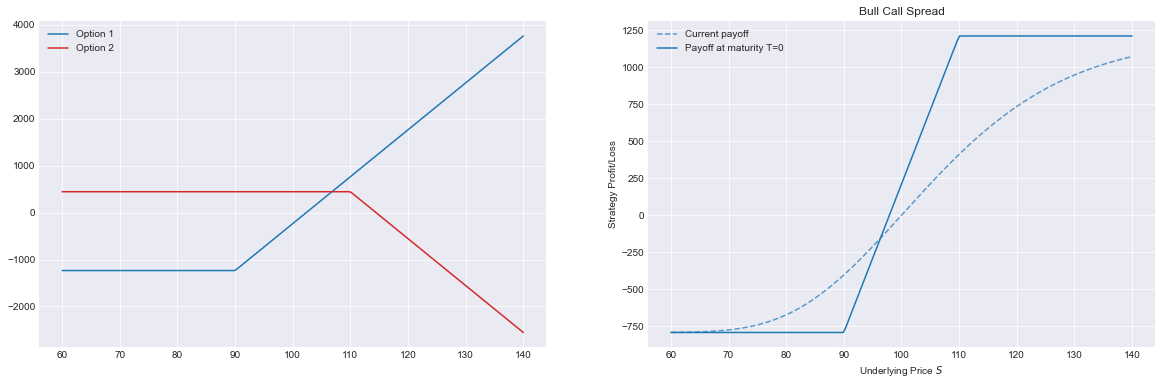

In [9]:
strat.plot_strategy(stratname)

In [10]:
strat.payoffs

60.000000     -789.809156
60.404040     -789.683117
60.808081     -789.537947
61.212121     -789.371347
61.616162     -789.180826
                 ...     
138.383838    1054.934952
138.787879    1058.929045
139.191919    1062.824203
139.595960    1066.622419
140.000000    1070.325666
Length: 199, dtype: float64

# Bull Spread

### Bull Spread using Calls

This is long in-the-money call ($K<S$) and short out-of-the-money call ($K>S$):

Bull Call Spread
(1) Long  Call (K=90.00, T=0.25, v=0.30) | Price = 12.52 | Quantity = 1
(2) Short Call (K=110.00, T=0.25, v=0.20) | Price = 1.09 | Quantity = -1
Cost of the strategy: Pay $1143.00


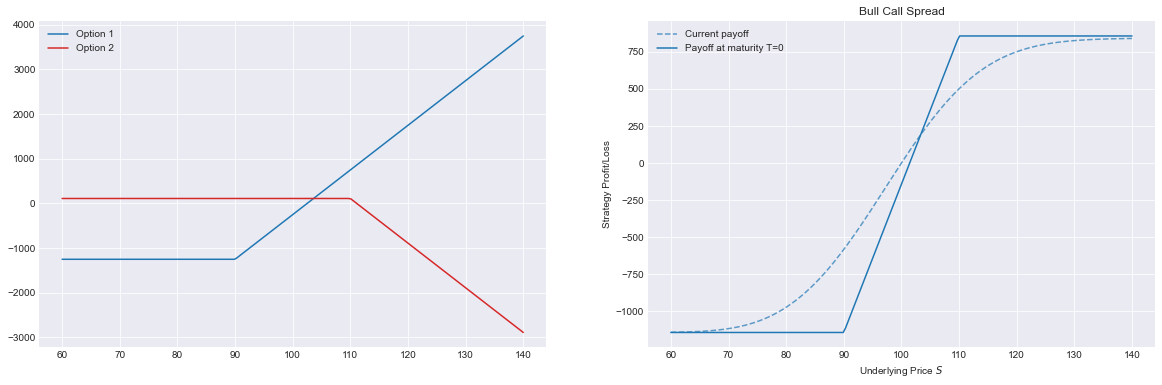

In [13]:
stratname = "Bull Call Spread"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=1,  K=90,  T=T, v=0.30)
strat.call(NP=-1, K=110, T=T, v=0.20)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

### Bull Spread using Puts

This is long out-of-the-money put ($K<S$) and short in-the-money put ($K>S$):

Bull Put Spread
(1) Long  Put (K=90.00, T=0.25, v=0.30) | Price = 1.85 | Quantity = 1
(2) Short Put (K=110.00, T=0.25, v=0.20) | Price = 10.27 | Quantity = -1
Cost of the strategy: Receive $842.00


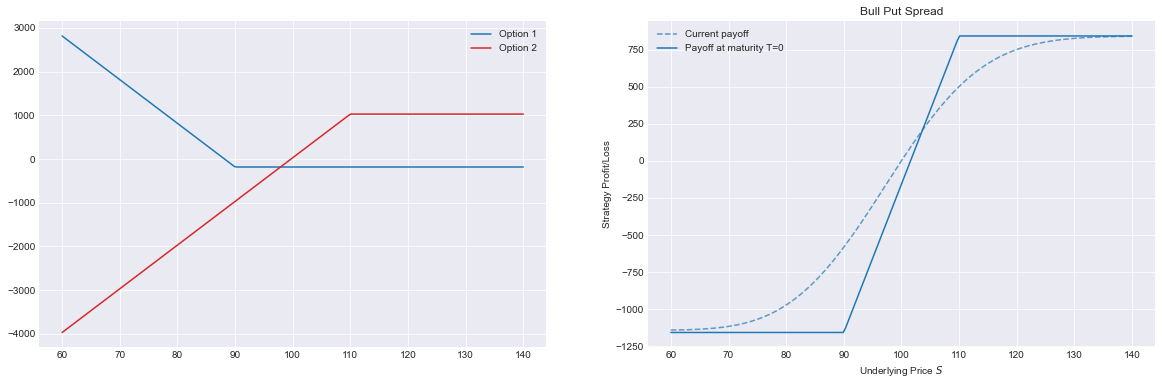

In [14]:
stratname = "Bull Put Spread"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.put(NP=1,  K=90,  T=T, v=0.30)
strat.put(NP=-1, K=110, T=T, v=0.20)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

# Bear Spreads

### Bear Spread using Calls

This is long out-of-the-money call ($K>S$) and short in-the-money call ($K<S$):

Bear Call Spread
(1) Long  Call (K=110.00, T=0.25, v=0.20) | Price = 1.09 | Quantity = 1
(2) Short Call (K=90.00, T=0.25, v=0.30) | Price = 12.52 | Quantity = -1
Cost of the strategy: Receive $1143.00


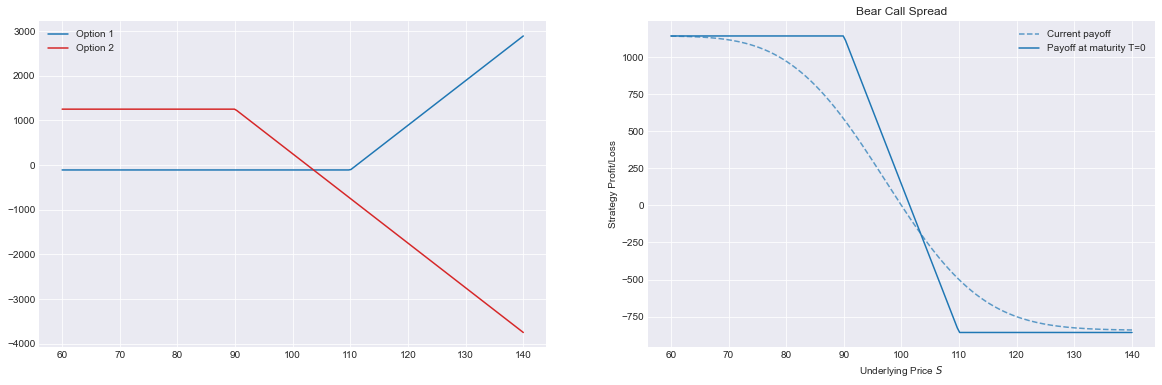

In [15]:
stratname = "Bear Call Spread"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=1,  K=110, T=T, v=0.20)
strat.call(NP=-1, K=90,  T=T, v=0.30)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

### Bear Spread using Puts

This is long in-the-money put ($K>S$) and short out-of-the-money put ($K<S$):

Bear Put Spread
(1) Long  Put (K=110.00, T=0.25, v=0.30) | Price = 11.88 | Quantity = 1
(2) Short Put (K=90.00, T=0.25, v=0.40) | Price = 3.37 | Quantity = -1
Cost of the strategy: Pay $851.00


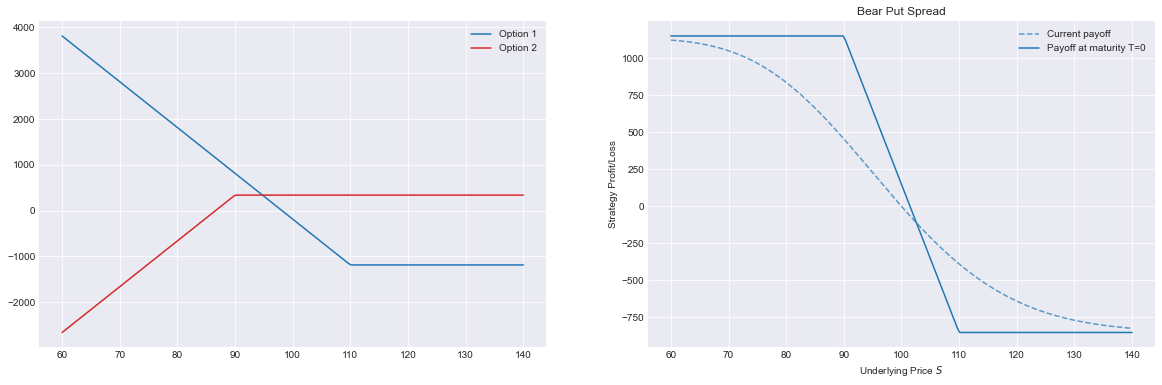

In [265]:
stratname = "Bear Put Spread"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.put(NP=1,  K=110, T=T, v=0.3)
strat.put(NP=-1, K=90,  T=T, v=0.4)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

# Straddles

### Bottom Straddle

This is long call and long put at the same strike

Bottom Straddle
(1) Long  Call (K=100.00, T=0.25, v=0.30) | Price = 6.34 | Quantity = 1
(2) Long  Put (K=100.00, T=0.25, v=0.34) | Price = 6.38 | Quantity = 1
Cost of the strategy: Pay $1272.00


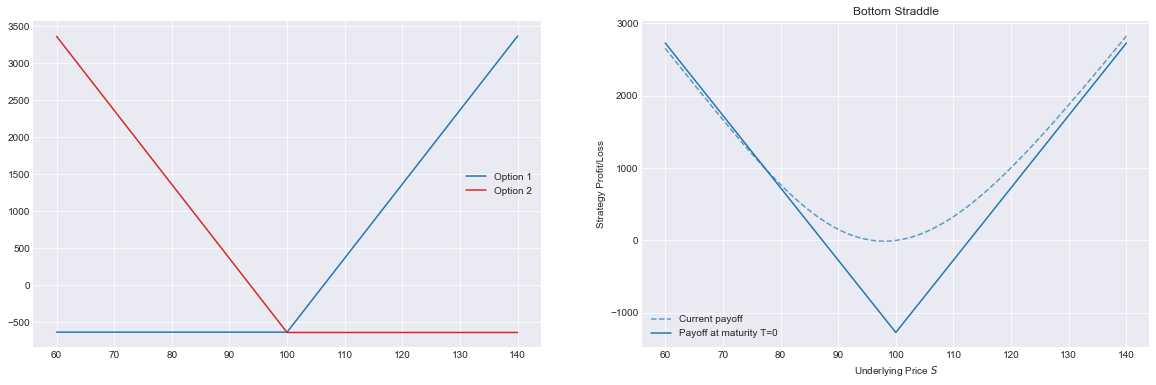

In [21]:
stratname = "Bottom Straddle"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=1, K=100, T=T, v=0.3)
strat.put(NP=1,  K=100, T=T, v=0.34)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

### Top Straddle

This is short call and short put at the same strike

Top Straddle
(1) Short Call (K=100.00, T=0.25, v=0.30) | Price = 6.34 | Quantity = -1
(2) Short Put (K=100.00, T=0.25, v=0.34) | Price = 6.38 | Quantity = -1
Cost of the strategy: Receive $1272.00


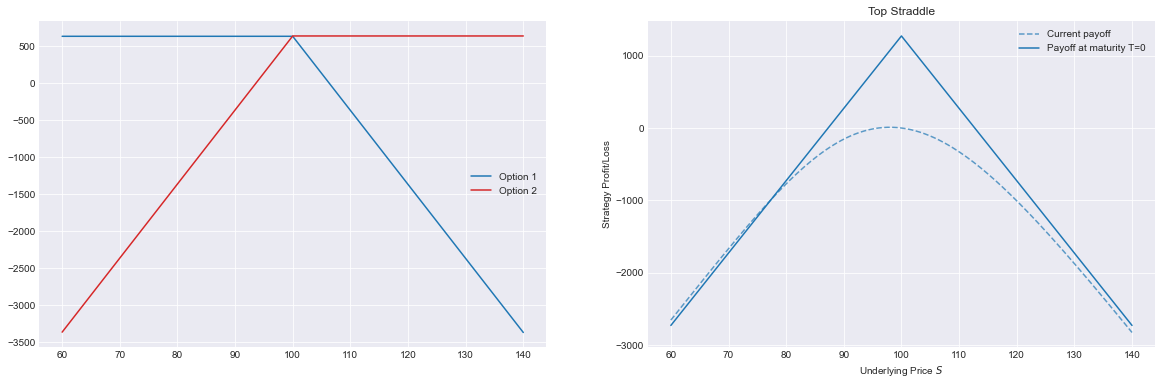

In [22]:
stratname = "Top Straddle"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=-1, K=100, T=T, v=0.3)
strat.put(NP=-1,  K=100, T=T, v=0.34)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

# Strangles

### Bottom Strangle

This is long call and long put at different strikes

Bottom Strangle
(1) Long  Call (K=110.00, T=0.25, v=0.20) | Price = 1.09 | Quantity = 1
(2) Long  Put (K=90.00, T=0.25, v=0.30) | Price = 1.85 | Quantity = 1
Cost of the strategy: Pay $294.00


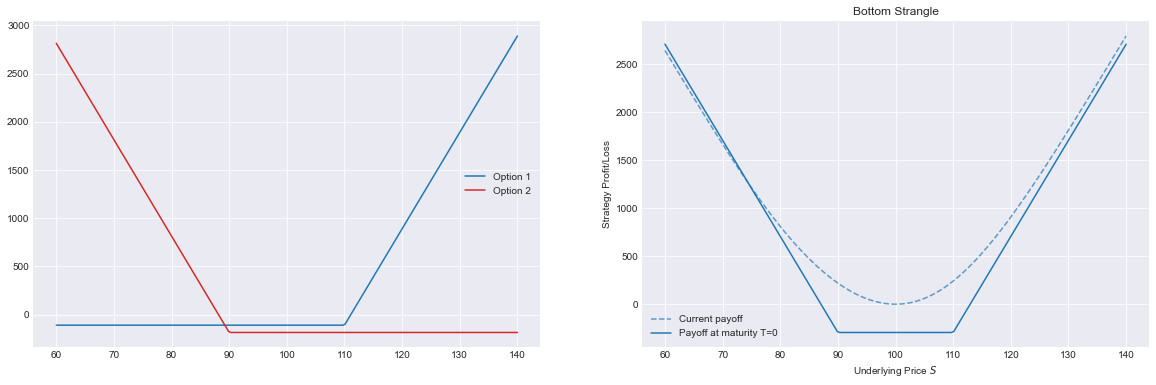

In [25]:
stratname = "Bottom Strangle" 
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=1, K=110, T=T, v=0.20)
strat.put(NP=1,  K=90,  T=T, v=0.30)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

### Top Strangle

This is short call and short put at different strikes

Top Strangle
(1) Short Call (K=110.00, T=0.25, v=0.20) | Price = 1.09 | Quantity = -1
(2) Short Put (K=90.00, T=0.25, v=0.30) | Price = 1.85 | Quantity = -1
Cost of the strategy: Receive $294.00


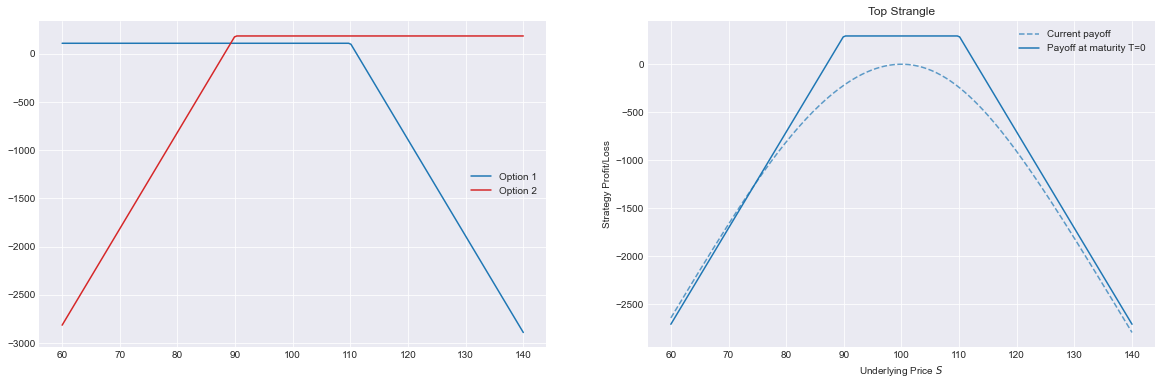

In [26]:
stratname = "Top Strangle" 
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=-1, K=110, T=T, v=0.20)
strat.put(NP=-1,  K=90,  T=T, v=0.30)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

# Butterflies

### Top Butterfly

Long 1 out-of-the money call, long 1 in-the-money call, and short two at-the-money calls

Top Butterfly
(1) Long  Call (K=80.00, T=0.25, v=0.30) | Price = 20.96 | Quantity = 1
(2) Long  Call (K=120.00, T=0.25, v=0.30) | Price = 0.98 | Quantity = 1
(3) Short Call (K=100.00, T=0.25, v=0.30) | Price = 6.34 | Quantity = -2
Cost of the strategy: Pay $926.00


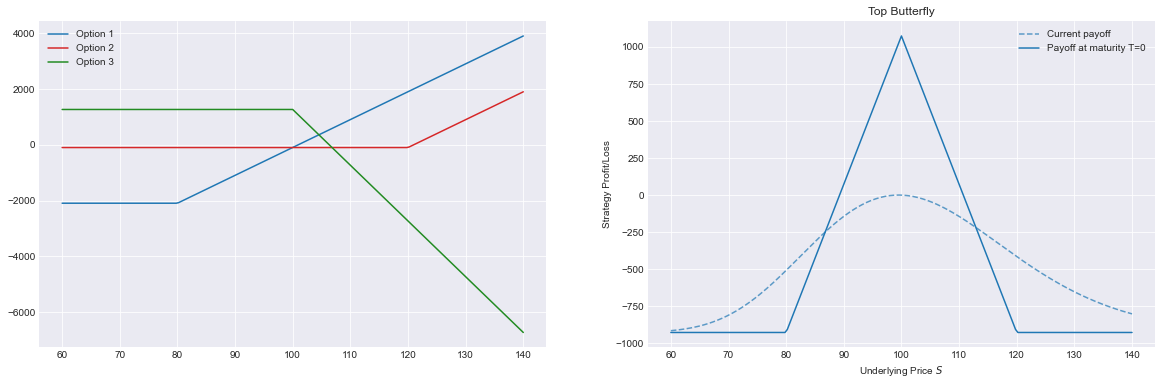

In [34]:
stratname = "Top Butterfly"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=1, K=80, T=T, v=0.3)
strat.call(NP=1, K=120, T=T, v=0.3)
strat.call(NP=-2, K=100, T=T, v=0.3)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

### Bottom Butterfly

Short 1 out-of-the money call, Short 1 in-the-money call, and long two at-the-money calls

Bottom Butterfly
(1) Short Call (K=80.00, T=0.25, v=0.30) | Price = 20.96 | Quantity = -1
(2) Short Call (K=120.00, T=0.25, v=0.30) | Price = 0.98 | Quantity = -1
(3) Long  Call (K=100.00, T=0.25, v=0.30) | Price = 6.34 | Quantity = 2
Cost of the strategy: Receive $926.00


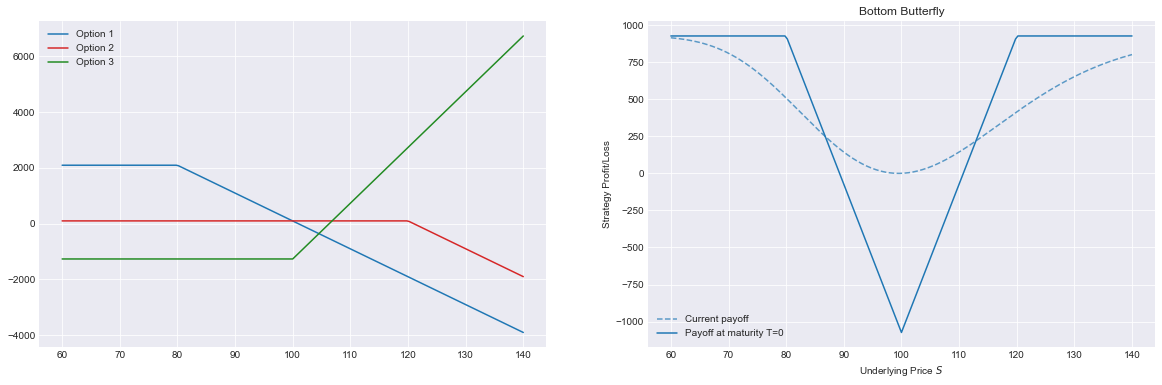

In [33]:
stratname = "Bottom Butterfly"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=-1, K=80, T=T, v=0.3)
strat.call(NP=-1, K=120, T=T, v=0.3)
strat.call(NP=2, K=100, T=T, v=0.3)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

# Iron Condors

### Top Iron Condor

This is equivalent to buying a Bear Call Spread and a Bull Put Spread simultaneously

Top Iron Condor
(1) Long  Call (K=120.00, T=0.25, v=0.30) | Price = 0.98 | Quantity = 1
(2) Short Call (K=110.00, T=0.25, v=0.30) | Price = 2.70 | Quantity = -1
(3) Long  Put (K=80.00, T=0.25, v=0.30) | Price = 0.36 | Quantity = 1
(4) Short Put (K=90.00, T=0.25, v=0.30) | Price = 1.85 | Quantity = -1
Cost of the strategy: Receive $321.00


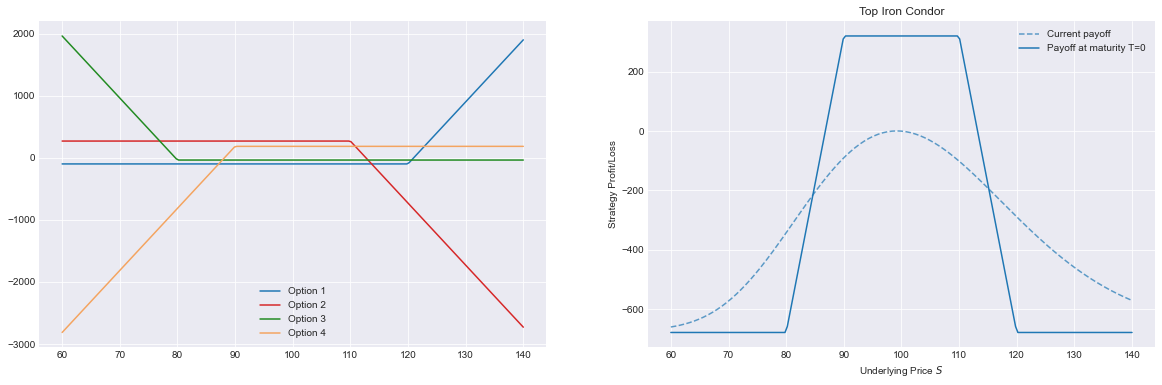

In [31]:
stratname = "Top Iron Condor"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

# Bear Call spread 
strat.call(NP=+1, K=120, T=T, v=0.30)
strat.call(NP=-1, K=110, T=T, v=0.30)
# Bull Put spread
strat.put(NP=+1, K=80, T=T, v=0.30)
strat.put(NP=-1, K=90, T=T, v=0.30)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

### Bottom Iron Condor

This is equivalent to buying a Bull Call Spread and a Bear Put Spread simultaneously

Bottom Iron Condor
(1) Short Call (K=120.00, T=0.25, v=0.30) | Price = 0.98 | Quantity = -1
(2) Long  Call (K=110.00, T=0.25, v=0.30) | Price = 2.70 | Quantity = 1
(3) Short Put (K=80.00, T=0.25, v=0.30) | Price = 0.36 | Quantity = -1
(4) Long  Put (K=90.00, T=0.25, v=0.30) | Price = 1.85 | Quantity = 1
Cost of the strategy: Pay $321.00


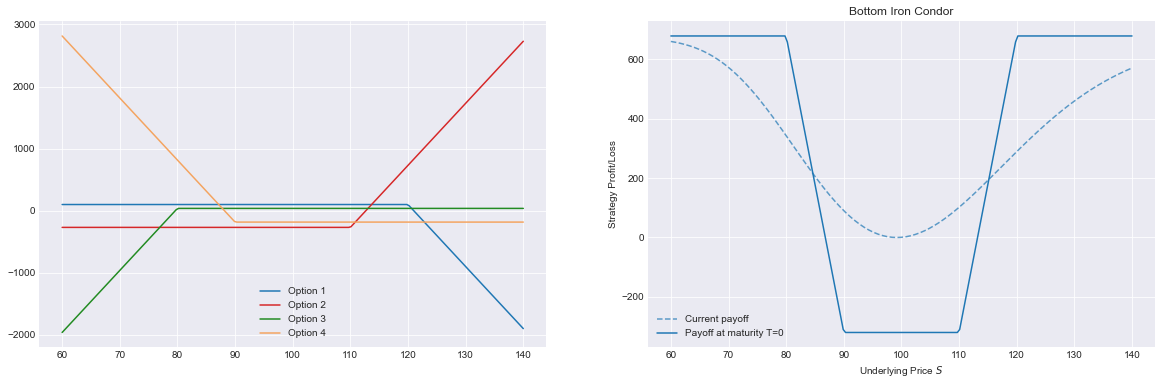

In [32]:
stratname = "Bottom Iron Condor"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

# Bull Call spread 
strat.call(NP=-1, K=120, T=T, v=0.30)
strat.call(NP=+1, K=110, T=T, v=0.30)
# Bear Put spread
strat.put(NP=-1, K=80, T=T, v=0.30)
strat.put(NP=+1, K=90, T=T, v=0.30)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

# Random strategy

Custom strategy
(1) Long  Call (K=100.00, T=0.25, v=0.18) | Price = 4.06 | Quantity = 7
(2) Long  Call (K=120.00, T=0.25, v=0.38) | Price = 2.00 | Quantity = 1
(3) Short Call (K=120.00, T=0.25, v=0.47) | Price = 3.39 | Quantity = -5
(4) Long  Put (K=90.00, T=0.25, v=0.30) | Price = 1.85 | Quantity = 4
(5) Short Put (K=75.00, T=0.25, v=0.30) | Price = 0.12 | Quantity = -10
Cost of the strategy: Pay $1967.00


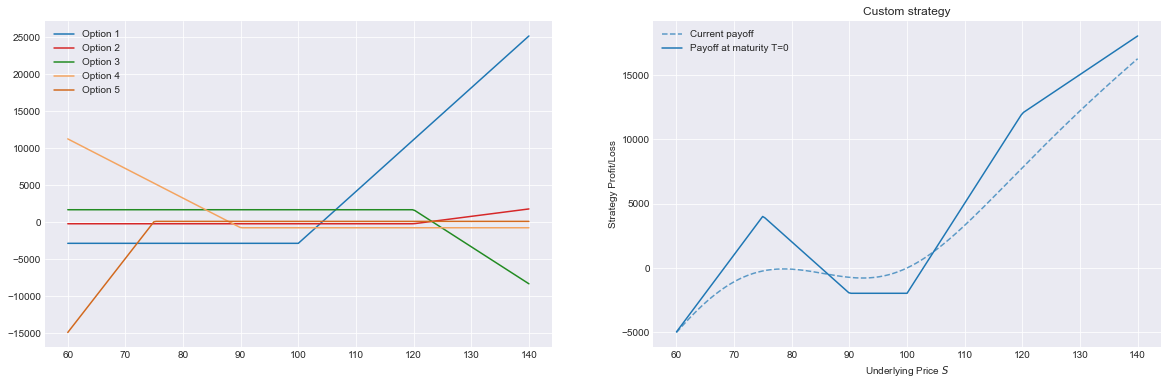

In [279]:
stratname = "Custom strategy"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=7, K=100, T=T, v=0.185)
strat.call(NP=1, K=120, T=T, v=0.38)
strat.call(NP=-5, K=120, T=T, v=0.47)
strat.put(NP=4, K=90, T=T, v=0.30)
strat.put(NP=-10, K=75, T=T, v=0.30)

strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

Bear Put Spread
(1) Short Call (K=110.00, T=0.25, v=0.30) | Price = 2.70 | Quantity = -1
(2) Short Put (K=90.00, T=0.25, v=0.34) | Price = 2.43 | Quantity = -1
Cost of the strategy: Receive $513.00


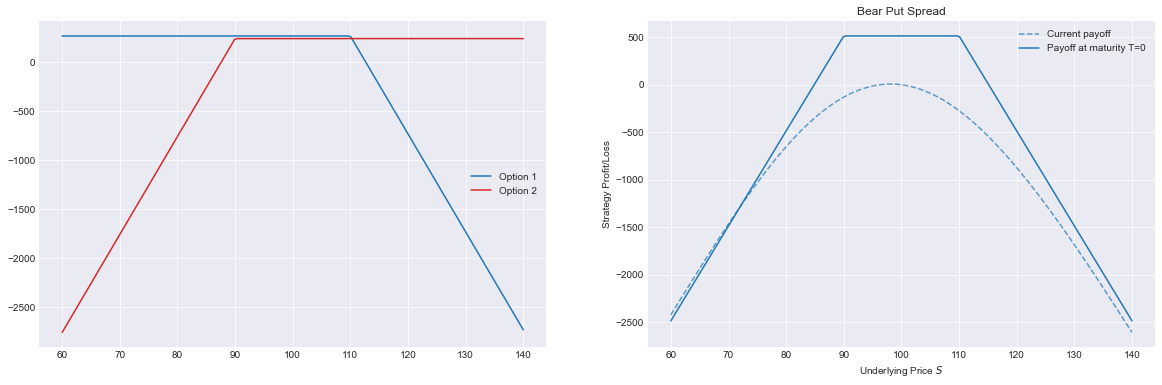

In [9]:
stratname = "Bear Put Spread"
strat = BSOptStrat(S=100, r=0.03, q=0)
T = 0.25

strat.call(NP=-1, K=110, T=T, v=0.3)
strat.put(NP=-1,  K=90, T=T, v=0.34)

desc = strat.describe_strategy(stratname)
strat.plot_strategy(stratname)

In [10]:
#desc

<AxesSubplot:>

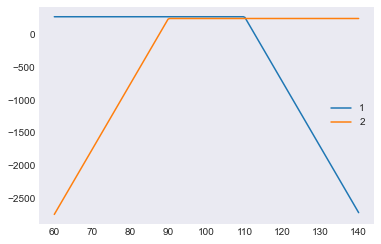

In [11]:
strat.get_payoffs_exp_df().plot()

<AxesSubplot:>

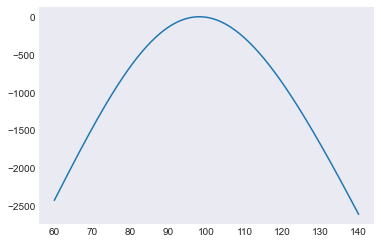

In [12]:
strat.get_payoffs().plot()

<AxesSubplot:>

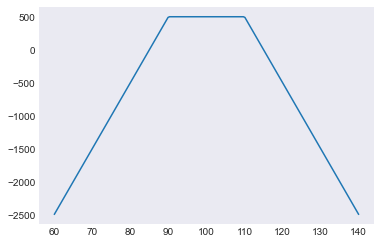

In [13]:
strat.get_payoffs_exp().plot()

In [18]:
stratname = "Long Iron Condor"
stratnew = BSOptStrat(S=100, r=0.03, q=0)
T = 0.01
dv = +0.2

stratnew.call(NP=-1, K=110, T=T, v=0.3+dv,  optprice=desc["Option_1"]["Pr"])
stratnew.put(NP=-1,  K=90,  T=T, v=0.34+dv, optprice=desc["Option_2"]["Pr"])

#stratnew.desc_strategy(stratname)
#stratnew.plot_strategy(stratname)

Text(0.5, 1.0, 'Long Iron Condor')

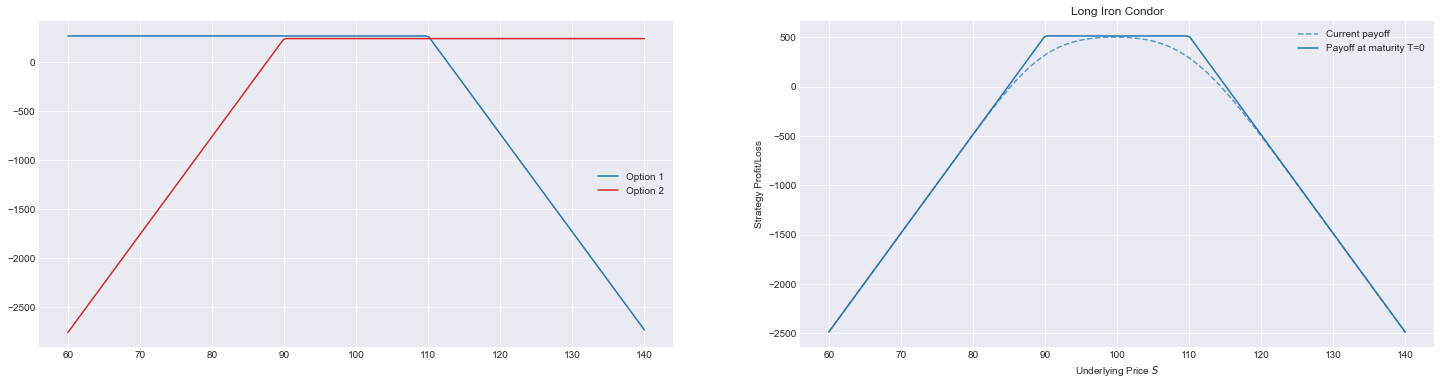

In [19]:
colors = ["tab:blue","tab:red","forestgreen","sandybrown","chocolate","gray"]

fig, ax = plt.subplots(1,2, figsize=(25,6)) 
ax = ax.flatten()

for n in range(1,strat.payoffs_exp_df.shape[1]+1):
    ax[0].plot(strat.payoffs_exp_df.index, strat.payoffs_exp_df[n], color=colors[n-1], label="Option {}".format(n))

ax[0].grid()
ax[0].legend()

expcol = "tab:blue"
ax[1].plot(stratnew.payoffs.index, stratnew.payoffs.values, color=expcol, linestyle="--", alpha=0.7, label="Current payoff")
ax[1].plot(strat.payoffs_exp.index, strat.payoffs_exp.values, color=expcol, linestyle="-", label="Payoff at maturity T=0", alpha=1)
#ax[1].fill_between(self.payoffs_exp.index, self.payoffs_exp.values,
#                   where=(self.payoffs_exp.values > 0), facecolor='g', alpha=0.4)
#ax[1].fill_between(self.payoffs_exp.index, self.payoffs_exp.values,
#                   where=(self.payoffs_exp.values < 0), facecolor='r', alpha=0.4)
ax[1].set_xlabel("Underlying Price $S$")
ax[1].set_ylabel("Strategy Profit/Loss")
ax[1].grid()
ax[1].legend()
ax[1].set_title(stratname)

In [336]:
T*365

0.0036500000000000005

In [628]:
S = 100
K = 90
T = 0.25
r = 0.01
sigma = 0.3 
q = 0

call = BSOption("C", S, K, 0, r, sigma, q=q)
call.price()

10

In [629]:
call.greeks()

{'Lambda': 10.0, 'Delta': 1, 'Gamma': 0, 'Theta': 0, 'Vega': 0}

In [33]:
put = BSOption("P", S, K, T, r, sigma, q=q)
put.price()

5.847048844192912

In [34]:
put.greeks()

{'Lambda': -7.93, 'Delta': -0.46, 'Gamma': 0.03, 'Theta': -11.4, 'Vega': 19.86}

In [280]:
stratname = "Straddle"

S = 100
r = 0.02
q = 0

SS = np.linspace(S*(1-0.5),S*(1+0.5),150)

In [284]:
# OPTION 1
K1 = 100
T1 = 0.5
v1 = 0.3 
opt_1 = BSOption("C", S, K1, T1, r, v1, q=q)
opt_1_payoff = opt_1.setprices() - 

In [217]:


K2 = 100
T2 = 0.5
v2 = 0.5 
putp = BSOption("P", S, K2, T2, r, v2, q=q).price()
p_payoff = [ BSOption("P", s, K2, T2, r, v2, q=q).price() - putp for s in SS ]
p_payoff_mat = [ BSOption("P", s, K2, 0, r, v2, q=q).price() - putp for s in SS ]

In [218]:
callp, putp

(8.91178851134395, 13.469830055944783)

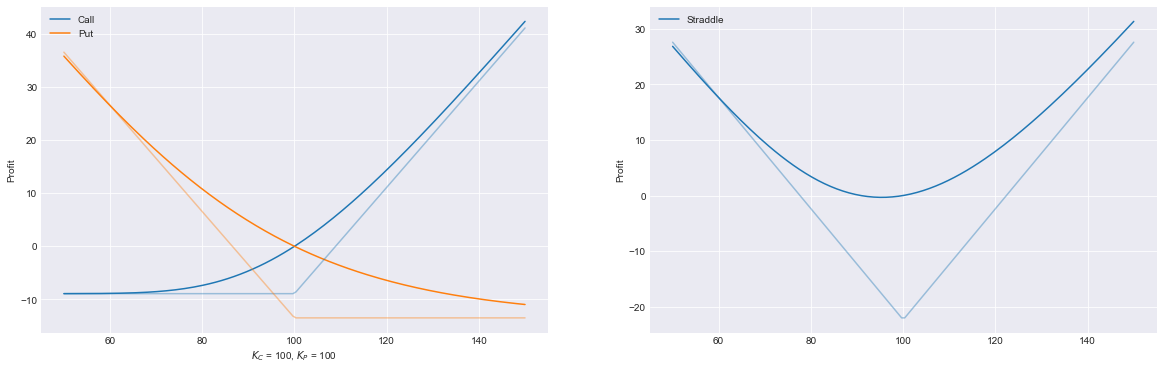

In [219]:
fig, ax = plt.subplots(1,2, figsize=(20,6)) 
ax = ax.flatten()

callcol = "tab:blue"
putcol  = "tab:orange"


ax[0].plot(SS, c_payoff, color = callcol, label="Call")
ax[0].plot(SS, p_payoff, color = putcol, label="Put")
#
ax[0].plot(SS, c_payoff_mat, color = callcol, alpha=0.4)
ax[0].plot(SS, p_payoff_mat, color = putcol, alpha=0.4)
#
ax[0].set_title("")
ax[0].set_xlabel("$K_C$ = {}, $K_P$ = {}".format(K1, K2))
ax[0].set_ylabel("Profit")
ax[0].grid()
ax[0].legend()


stratdf = pd.DataFrame([c_payoff, p_payoff], index=["Call","Put"]).T
strat_payoff = stratdf.apply(lambda x: +x["Call"] + x["Put"], axis=1)
#
stratdf_mat = pd.DataFrame([c_payoff_mat, p_payoff_mat], index=["Call","Put"]).T
strat_payoff_mat = stratdf_mat.apply(lambda x: +x["Call"] + x["Put"], axis=1)
#
ax[1].plot(SS, strat_payoff.values, color="tab:blue", label="{}".format(stratname))
ax[1].plot(SS, strat_payoff_mat.values, color="tab:blue", alpha = 0.4)
ax[1].set_ylabel("Profit")
ax[1].grid()
ax[1].legend()

plt.show()

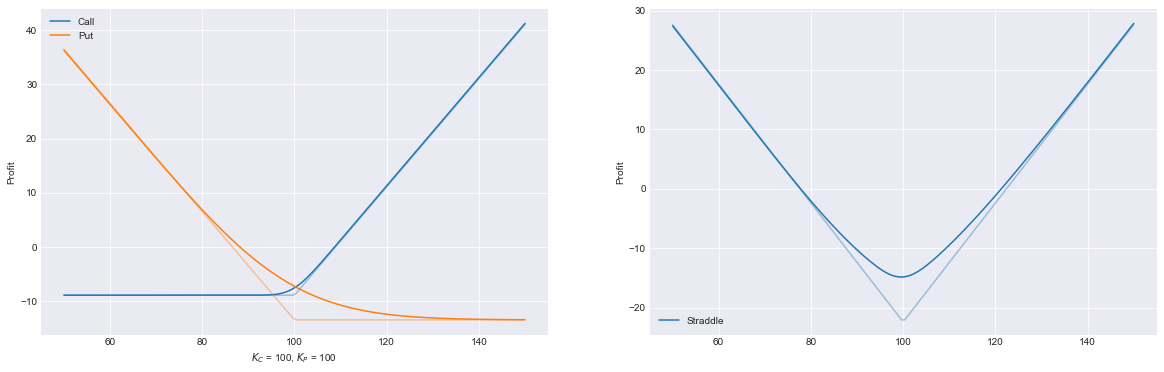

In [226]:
T1 = 0.1
v1 = 0.1 
c_payoff = [ BSOption("C", s, K1, T1, r, v1, q=q).price() - callp for s in SS ]
c_payoff_mat = [ BSOption("C", s, K1, 0, r, v1, q=q).price() - callp for s in SS ]


T2 = T1
p_payoff = [ BSOption("P", s, K2, T2, r, v2, q=q).price() - putp for s in SS ]
p_payoff_mat = [ BSOption("P", s, K2, 0, r, v2, q=q).price() - putp for s in SS ]

fig, ax = plt.subplots(1,2, figsize=(20,6)) 
ax = ax.flatten()

callcol = "tab:blue"
putcol  = "tab:orange"


ax[0].plot(SS, c_payoff, color = callcol, label="Call")
ax[0].plot(SS, p_payoff, color = putcol, label="Put")
#
ax[0].plot(SS, c_payoff_mat, color = callcol, alpha=0.4)
ax[0].plot(SS, p_payoff_mat, color = putcol, alpha=0.4)
#
ax[0].set_title("")
ax[0].set_xlabel("$K_C$ = {}, $K_P$ = {}".format(K1, K2))
ax[0].set_ylabel("Profit")
ax[0].grid()
ax[0].legend()


stratdf = pd.DataFrame([c_payoff, p_payoff], index=["Call","Put"]).T
strat_payoff = stratdf.apply(lambda x: +x["Call"] + x["Put"], axis=1)
#
stratdf_mat = pd.DataFrame([c_payoff_mat, p_payoff_mat], index=["Call","Put"]).T
strat_payoff_mat = stratdf_mat.apply(lambda x: +x["Call"] + x["Put"], axis=1)
#
ax[1].plot(SS, strat_payoff.values, color="tab:blue", label="{}".format(stratname))
ax[1].plot(SS, strat_payoff_mat.values, color="tab:blue", alpha = 0.4)
ax[1].set_ylabel("Profit")
ax[1].grid()
ax[1].legend()

plt.show()

0      37.636134
1      36.964993
2      36.293853
3      35.622712
4      34.951571
         ...    
145    35.951571
146    36.622712
147    37.293853
148    37.964993
149    38.636134
Length: 150, dtype: float64

## Call price versus strike price 

In [81]:
SS = np.linspace(80,120,100)
#S = 100
r = 0.01
T = 0.25
sigma = 0.3 
q = 0

K1 = 90
K2 = 100
K3 = 110

call1 = [ BSOption("C", s, K1, T, r, sigma, q=q) for s in SS ]
call2 = [ BSOption("C", s, K2, T, r, sigma, q=q) for s in SS ]
call3 = [ BSOption("C", s, K3, T, r, sigma, q=q) for s in SS ]

In [82]:
K = np.linspace(80,120,100)
S = 100
r = 0.01
T = 0.25
sigma = 0.3 
q = 0

Call1 = [ BSOption("C", S, k, T, r, sigma, q=q) for k in K ]

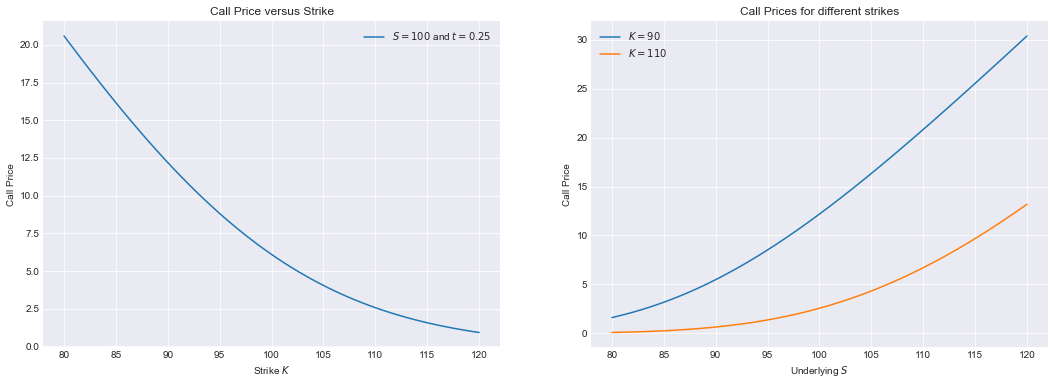

In [83]:
fig, ax = plt.subplots(1,2, figsize=(18,6)) 
ax = ax.flatten()

ax[0].plot(K, [c.price() for c in Call1], label="$S={:.0f}$ and $t=0.25$".format(S))
ax[0].set_title("Call Price versus Strike")
ax[0].set_xlabel("Strike $K$")
ax[0].set_ylabel("Call Price")
ax[0].grid()
ax[0].legend()

ax[1].plot(SS, [c.price() for c in call1], label="$K={:.0f}$".format(K1))
ax[1].plot(SS, [c.price() for c in call3], label="$K={:.0f}$".format(K3))
ax[1].set_title("Call Prices for different strikes")
ax[1].set_xlabel("Underlying $S$")
ax[1].set_ylabel("Call Price")
ax[1].grid()
ax[1].legend()

plt.show()

## Call Option bounds 

In [13]:
# Fix a strike and the rest of parameters
K = 50
r = 0.01
sigma = 0.3 
q = 0

# Set of underlyings
S = np.linspace(0.01,100,200)

# Set of maturities
T = [100, 20, 8, 0]

# Calls and Puts
call1 = [df.BSOption("C", s, K, T[0], r, sigma, q=q) for s in S]
call2 = [df.BSOption("C", s, K, T[1], r, sigma, q=q) for s in S]
call3 = [df.BSOption("C", s, K, T[2], r, sigma, q=q) for s in S]
call4 = [df.BSOption("C", s, K, T[3], r, sigma, q=q) for s in S]

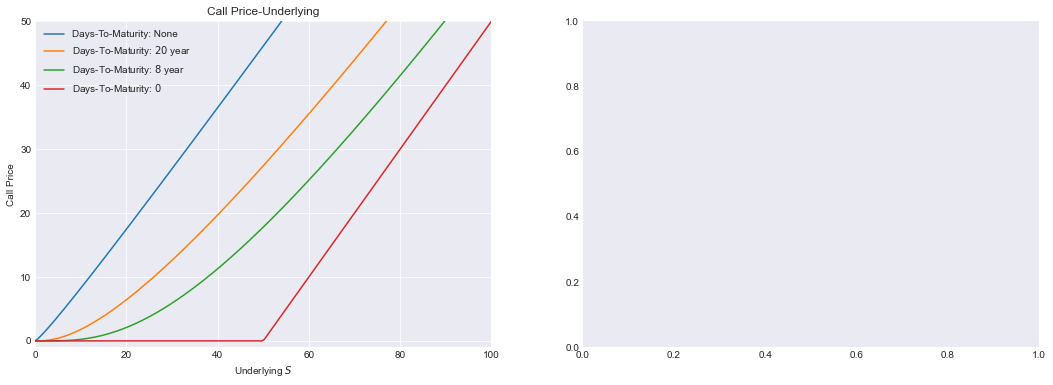

In [14]:
fig, ax = plt.subplots(1,2, figsize=(18,6)) 
ax = ax.flatten()

# Calls
ax[0].plot(S, [c.price() for c in call1], label="Days-To-Maturity: None")
ax[0].plot(S, [c.price() for c in call2], label="Days-To-Maturity: ${:.0f}$ year".format(T[1]))
ax[0].plot(S, [c.price() for c in call3], label="Days-To-Maturity: ${:.0f}$ year".format(T[2]))
ax[0].plot(S, [c.price() for c in call4], label="Days-To-Maturity: $0$")
ax[0].set_title("Call Price-Underlying")
ax[0].set_xlabel("Underlying $S$") # (Strike $K={:.0f}$)".format(K))
ax[0].set_ylabel("Call Price")
ax[0].set_ylim([-1,50])
ax[0].set_xlim([0,100])
ax[0].grid()
ax[0].legend()

plt.show()

## Option Return versus Underlying return

In [15]:
# Fix a strike and the rest of parameters
K = 100
r = 0.01
T = 0.3
sigma = 0.3 
q = 0

# Calls
S = np.linspace(80,120,25)
#
calls = [ df.BSOption("C", s, K, T, r, sigma, q=q) for s in S]

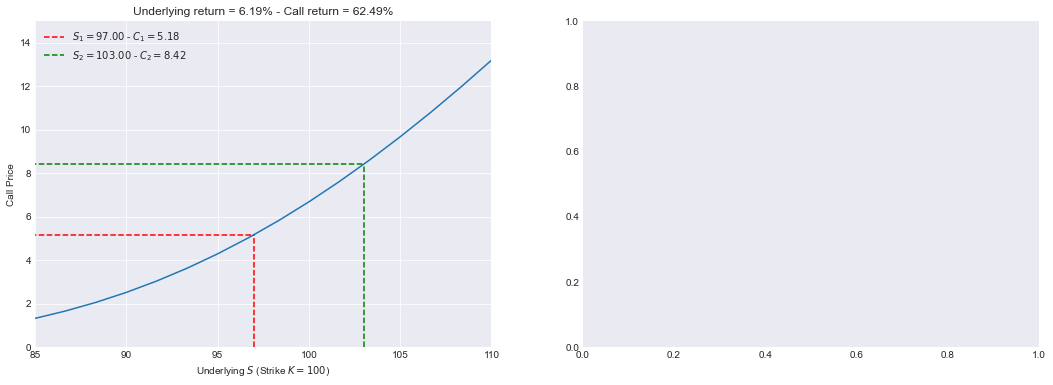

In [16]:
fig, ax = plt.subplots(1,2, figsize=(18,6)) 
ax = ax.flatten()

# Calls
ax[0].plot(S, [c.price() for c in calls], label="")

S1 = 97
C1 = df.BSOption("C", S1, K, T, r, sigma, q=q).price()
ax[0].plot([S1, S1], [0, C1], c='red', linestyle="--") 
ax[0].plot([0, S1], [C1, C1], 
           c='red', 
           linestyle="--", 
           label="$S_1={:.2f}$ - $C_1={:.2f}$".format(S1,C1)) 

S2 = 103
C2 = df.BSOption("C", S2, K, T, r, sigma, q=q).price()
ax[0].plot([S2, S2], [0, C2], c='green', linestyle="--") 
ax[0].plot([0, S2], [C2, C2], 
           c='green', 
           linestyle="--", 
           label="$S_2={:.2f}$ - $C_2={:.2f}$".format(S2,C2)) 

ax[0].set_title("Underlying return = {:.2f}% - Call return = {:.2f}%".format((S2/S1-1)*100, (C2/C1-1)*100))
ax[0].set_xlabel("Underlying $S$ (Strike $K=100$)")
ax[0].set_ylabel("Call Price")
ax[0].set_ylim([0,15])
ax[0].set_xlim([85,110])
ax[0].grid()
ax[0].legend()

plt.show()

## Moneyness of Calls and Puts

In [17]:
# Fix a strike and the rest of parameters
K = 100
r = 0.01
T = 0.25
sigma = 0.3 
q = 0

# Calls
SC_OTM = np.linspace(80,99,25)
SC_ATM = np.linspace(99,101,10)
SC_ITM = np.linspace(101,120,25)
#
calls_OTM = [ df.BSOption("C", s, K, T, r, sigma, q=q) for s in SC_OTM ]
calls_ATM = [ df.BSOption("C", s, K, T, r, sigma, q=q) for s in SC_ATM ]
calls_ITM = [ df.BSOption("C", s, K, T, r, sigma, q=q) for s in SC_ITM ]


# Puts
SP_ITM = np.linspace(80,99,25)
SP_ATM = np.linspace(99,101,10)
SP_OTM = np.linspace(101,120,25)
#
puts_ITM = [ df.BSOption("P", s, K, T, r, sigma, q=q) for s in SP_ITM ]
puts_ATM = [ df.BSOption("P", s, K, T, r, sigma, q=q) for s in SP_ATM ]
puts_OTM = [ df.BSOption("P", s, K, T, r, sigma, q=q) for s in SP_OTM ]

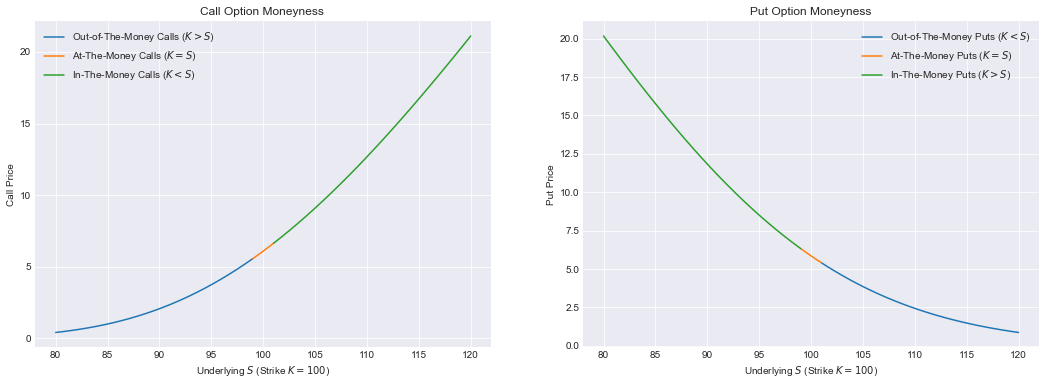

In [18]:
fig, ax = plt.subplots(1,2, figsize=(18,6)) 
ax = ax.flatten()

# Calls
ax[0].plot(SC_OTM, [c.price() for c in calls_OTM], label="Out-of-The-Money Calls ($K > S$)")
ax[0].plot(SC_ATM, [c.price() for c in calls_ATM], label="At-The-Money Calls ($K = S$)")
ax[0].plot(SC_ITM, [c.price() for c in calls_ITM], label="In-The-Money Calls ($K < S$)")
ax[0].set_title("Call Option Moneyness ")
ax[0].set_xlabel("Underlying $S$ (Strike $K=100$)")
ax[0].set_ylabel("Call Price")
ax[0].grid()
ax[0].legend()

# Puts
ax[1].plot(SP_OTM, [p.price() for p in puts_OTM], label="Out-of-The-Money Puts ($K < S$)")
ax[1].plot(SP_ATM, [p.price() for p in puts_ATM], label="At-The-Money Puts ($K = S$)")
ax[1].plot(SP_ITM, [p.price() for p in puts_ITM], label="In-The-Money Puts ($K > S$)")
ax[1].set_title("Put Option Moneyness")
ax[1].set_xlabel("Underlying $S$ (Strike $K=100$)")
ax[1].set_ylabel("Put Price")
ax[1].grid()
ax[1].legend()

plt.show()

#### ITM Call

In [19]:
n = 12
Sn = SC_ITM[n]
Cn = [c.price() for c in calls_ITM][n]
intr_value = max(Sn - K,0)
time_value = Cn - intr_value

round(Sn,2), round(Cn,2), round(intr_value,2), round(time_value,2)

(110.5, 13.06, 10.5, 2.56)

#### OTM Call

In [20]:
n = 18
Sn = SC_OTM[n]
Cn = [c.price() for c in calls_OTM][n]
intr_value = max(Sn - K,0)
time_value = Cn - intr_value

round(Sn,2), round(Cn,2), round(intr_value,2), round(time_value,2)

(94.25, 3.46, 0, 3.46)

#### ITM Put

In [21]:
n = 12
Sn = SP_ITM[n]
Pn = [p.price() for p in puts_ITM][n]
intr_value = max(K - Sn,0)
time_value = Pn - intr_value

round(Sn,2), round(Pn,2), round(intr_value,2), round(time_value,2)

(89.5, 12.19, 10.5, 1.69)

#### OTM Put

In [22]:
n = 10
Sn = SP_OTM[n]
Pn = [p.price() for p in puts_OTM][n]
intr_value = max(K - Sn,0)
time_value = Pn - intr_value

round(Sn,2), round(Pn,2), round(intr_value,2), round(time_value,2)

(108.92, 2.69, 0, 2.69)

## The effect of time: price evolution 

In [23]:
# Fix a strike and the rest of parameters
K = 100
r = 0.01
sigma = 0.3 
q = 0

# Set of underlyings
S = np.linspace(80,120,100)

# Set of maturities
T = [2.5, 1.5, 0.9, 0.3, 0.1, 0.05, 0.02, 0]

# Calls and Puts
calls = [ [df.BSOption("C", s, K, t, r, sigma, q=q) for s in S] for t in T]
puts  = [ [df.BSOption("P", s, K, t, r, sigma, q=q) for s in S] for t in T]

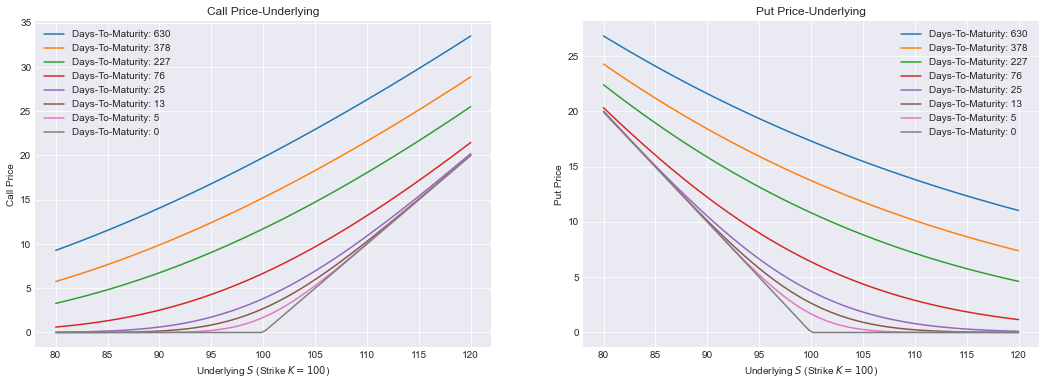

In [24]:
fig, ax = plt.subplots(1,2, figsize=(18,6)) 
ax = ax.flatten()

# Calls
for t in range(len(T)):
    ax[0].plot(S, [c.price() for c in calls[t]], label="Days-To-Maturity: {:.0f} ".format(round(T[t]*252,0)))
ax[0].set_title("Call Price-Underlying")
ax[0].set_xlabel("Underlying $S$ (Strike $K=100$)")
ax[0].set_ylabel("Call Price")
ax[0].grid()
ax[0].legend()

# Puts
for t in range(len(T)):
    ax[1].plot(S, [p.price() for p in puts[t]], label="Days-To-Maturity: {:.0f} ".format(round(T[t]*252,0)))
ax[1].set_title("Put Price-Underlying")
ax[1].set_xlabel("Underlying $S$ (Strike $K=100$)")
ax[1].set_ylabel("Put Price")
ax[1].grid()
ax[1].legend()

plt.show()

## The effect of volatility: 

In [25]:
# Set of volatility 
sigmas = np.linspace(0.01,1,100)

# Rest of parameters
S = 100
K = 100
T = 1
q = 0

# Different interest rates
r_1 = 0.1
r_2 = 0.05
r_3 = 0.01

# Calls and Puts
calls_1 = [ df.BSOption("C", S, K, T, r_1, ss, q=q) for ss in sigmas ]
puts_1  = [ df.BSOption("P", S, K, T, r_1, ss, q=q) for ss in sigmas ]

calls_2 = [ df.BSOption("C", S, K, T, r_2, ss, q=q) for ss in sigmas ]
puts_2  = [ df.BSOption("P", S, K, T, r_2, ss, q=q) for ss in sigmas ]

calls_3 = [ df.BSOption("C", S, K, T, r_3, ss, q=q) for ss in sigmas ]
puts_3  = [ df.BSOption("P", S, K, T, r_3, ss, q=q) for ss in sigmas ]

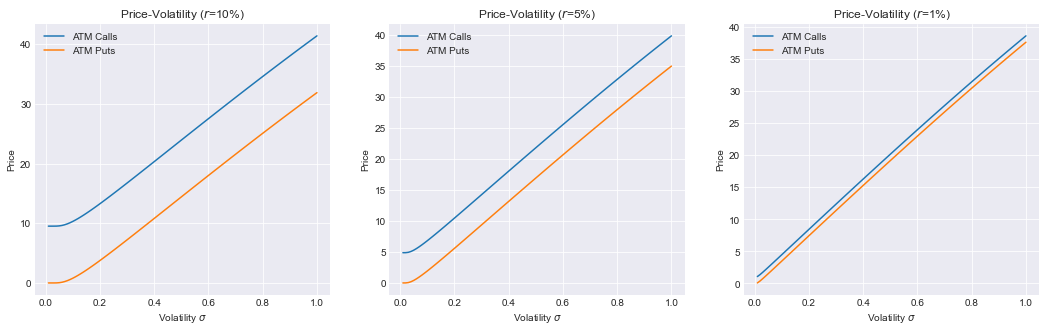

In [26]:
fig, ax = plt.subplots(1,3, figsize=(18,5)) 
ax = ax.flatten()

ax[0].plot(sigmas, [c.price() for c in calls_1], label="ATM Calls")
ax[0].plot(sigmas, [p.price() for p in puts_1],  label="ATM Puts")
ax[0].set_title("Price-Volatility ($r$={:.0f}%)".format(r_1*100))
ax[0].set_xlabel("Volatility $\sigma$")
ax[0].set_ylabel("Price")
ax[0].grid()
ax[0].legend()

ax[1].plot(sigmas, [c.price() for c in calls_2], label="ATM Calls")
ax[1].plot(sigmas, [p.price() for p in puts_2],  label="ATM Puts")
ax[1].set_title("Price-Volatility ($r$={:.0f}%)".format(r_2*100))
ax[1].set_xlabel("Volatility $\sigma$")
ax[1].set_ylabel("Price")
ax[1].grid()
ax[1].legend()

ax[2].plot(sigmas, [c.price() for c in calls_3], label="ATM Calls")
ax[2].plot(sigmas, [p.price() for p in puts_3],  label="ATM Puts")
ax[2].set_title("Price-Volatility ($r$={:.0f}%)".format(r_3*100))
ax[2].set_xlabel("Volatility $\sigma$")
ax[2].set_ylabel("Price")
ax[2].grid()
ax[2].legend()

plt.show()

## Payoff - Profit for a Long Call/Put

In [46]:
# Current Underlying
S0 = 100

# Fix a strike and the rest of parameters
K = 105
T = 0.5
r = 0.01
sigma = 0.2794
q = 0

# Current Call and Put price at maturity 
C = df.BSOption("C", S0, K, T, r, sigma, q=q).price()
P = df.BSOption("P", S0, K, T, r, sigma, q=q).price()
np.round(C,2), np.round(P,2)

(6.0, 10.48)

In [47]:
# Set of underlyings at maturity
S = np.linspace(85,125,150)

# At maturity 
T = 0

# Calls and Puts
calls = [ df.BSOption("C", s, K, T, r, sigma, q=q) for s in S ]
puts  = [ df.BSOption("P", s, K, T, r, sigma, q=q) for s in S ]

### Long Call/Put

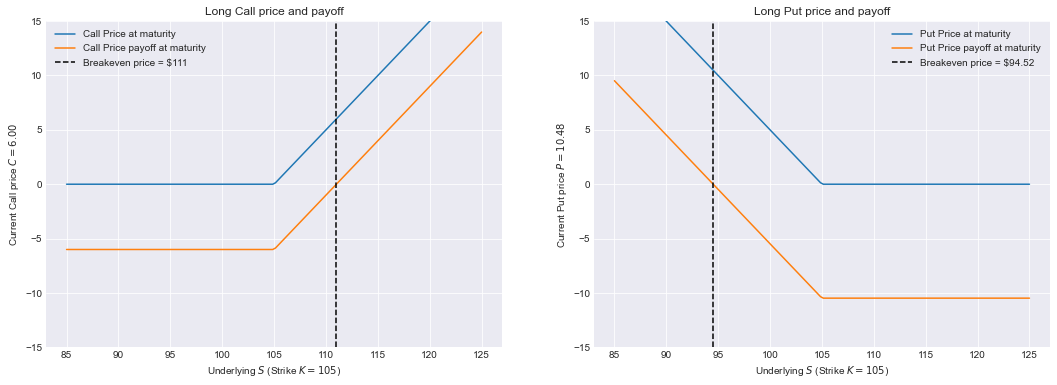

In [48]:
fig, ax = plt.subplots(1,2, figsize=(18,6)) 
ax = ax.flatten()

# Calls
ax[0].plot(S, [c.price() for c in calls],     label="Call Price at maturity")
ax[0].plot(S, [c.price() for c in calls] - C, label="Call Price payoff at maturity")
ax[0].axvline(x=K + C, color="k", linestyle="--", label="Breakeven price = ${:.0f}".format(K+C))
ax[0].set_title("Long Call price and payoff")
ax[0].set_xlabel("Underlying $S$ (Strike $K={:.0f}$)".format(K))
ax[0].set_ylabel("Current Call price $C={:.2f}$".format(C))
ax[0].set_ylim([-15,15])
ax[0].grid()
ax[0].legend()

# Puts
ax[1].plot(S, [p.price() for p in puts],     label="Put Price at maturity")
ax[1].plot(S, [p.price() for p in puts] - P, label="Put Price payoff at maturity")
ax[1].axvline(x=K - P, color="k", linestyle="--", label="Breakeven price = ${:.2f}".format(K-P))
ax[1].set_title("Long Put price and payoff")
ax[1].set_xlabel("Underlying $S$ (Strike $K={:.0f}$)".format(K))
ax[1].set_ylabel("Current Put price $P={:.2f}$".format(P))
ax[1].set_ylim([-15,15])
ax[1].grid()
ax[1].legend()

plt.show()

### Short Call/Put

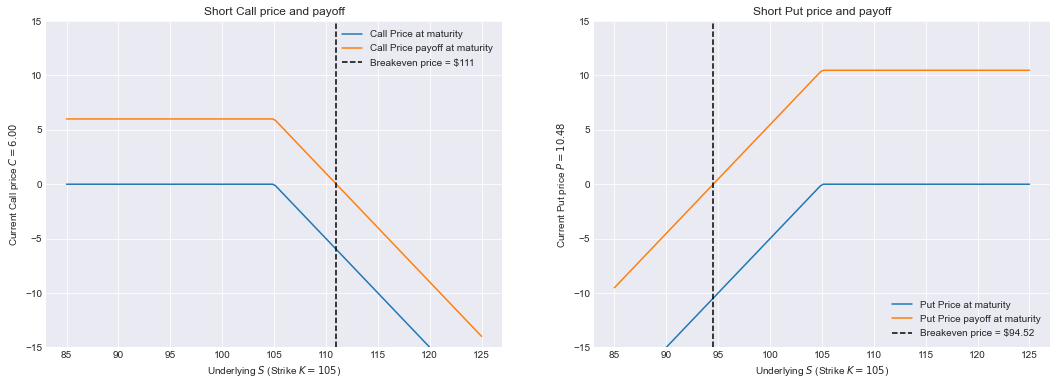

In [49]:
fig, ax = plt.subplots(1,2, figsize=(18,6)) 
ax = ax.flatten()

# Calls
ax[0].plot(S, [-c.price() for c in calls],     label="Call Price at maturity")
ax[0].plot(S, [-c.price() for c in calls] + C, label="Call Price payoff at maturity")
ax[0].axvline(x=K + C, color="k", linestyle="--", label="Breakeven price = ${:.0f}".format(K+C))
ax[0].set_title("Short Call price and payoff")
ax[0].set_xlabel("Underlying $S$ (Strike $K={:.0f}$)".format(K))
ax[0].set_ylabel("Current Call price $C={:.2f}$".format(C))
ax[0].set_ylim([-15,15])
ax[0].grid()
ax[0].legend()

# Puts
ax[1].plot(S, [-p.price() for p in puts],     label="Put Price at maturity")
ax[1].plot(S, [-p.price() for p in puts] + P, label="Put Price payoff at maturity")
ax[1].axvline(x=K - P, color="k", linestyle="--", label="Breakeven price = ${:.2f}".format(K-P))
ax[1].set_title("Short Put price and payoff")
ax[1].set_xlabel("Underlying $S$ (Strike $K={:.0f}$)".format(K))
ax[1].set_ylabel("Current Put price $P={:.2f}$".format(P))
ax[1].set_ylim([-15,15])
ax[1].grid()
ax[1].legend()

plt.show()

In [468]:
# Fix a strike and the rest of parameters
Smin  = 80
Smax  = 120
nres  = 100
S     = np.linspace(Smin,Smax,nres)
K     = 100
r     = 2
sigma = 2
q     = 0
T     = 0.1

# Calls and Puts
option = [BSOption("C", s, K, T, r/100, sigma/100, q=q) for s in S]

In [464]:
S = 90
option = BSOption("C", S, K, T, r/100, sigma/100, q=q)
price = option.price()
delta = option.delta()
Lambda = option.Lambda()
price, delta, Lambda, delta * S / price

(1.14992829796763e-236, 1.3231646560615337e-234, inf, 10355.847339004282)

In [469]:
lambdas = [o.Lambda() for o in option]

In [470]:
lambdas

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 1181.6036418928034,
 1079.6890005411722,
 978.9113299425829,
 879.4590833155868,
 781.5916584097956,
 685.6707244402598,
 592.2060400843047,
 501.9204526775568,
 415.8353783519955,
 335.3636512356621,
 262.35736862906464,
 198.98430741608075,
 147.24607848145018,
 108.0993581300984,
 80.6733160914434,
 62.44368762797593,
 50.41341838847763,
 42.20199964657132,
 36.31402997518302,
 31.896900153450922,
 28.461820700270028,
 25.71412906116784,
 23.466267217965846,
 21.593220635431834,
 20.008456913172857,
 18.650176897897982,
 17.473067249420367,
 16.44314685427735,
 15.53443274024158,
 14.726717692018319,
 14.00404987552839,
 13.353668700249992,
 12.76524480046443,
 12.230327346126202,
 11.741935567958427,
 11.29425242465971,
 10.882391806143218,
 10.502219470461

In [472]:
lambdas[min(np.where(np.array(lambdas) < +np.inf)[0])]

1181.6036418928034

In [408]:
price

4.1037046835332496e-16

In [409]:
10**(-13) / 10**(-16)

1000.0

In [410]:
-2.1327384303049257 / 4.1037046835332496

-0.5197105042336181

In [400]:
1e-18

1e-18

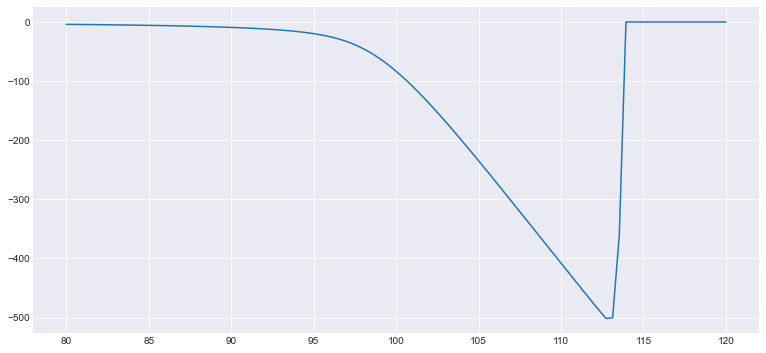

In [339]:
fig, ax = plt.subplots(1,1,figsize=(13,6))
greeks = [o.Lambda() for o in option]
ax.plot(S, greeks , color="tab:blue")
ax.grid()
plt.show()

Suppose a fixed underlying price $S$ and the rest of option parameters being fixed as well. Compute the current option price and the corresponding Lambda.

In [325]:
# Fixed underlying price
S1 = 100

# Option
option = BSOption("C", S1, K, T, r/100, sigma/100, q=q)

# Option price and lambda
Price1 = option.price()
Lambda = option.Lambda()

In [326]:
print("Current underlying price:\t{:.2f}".format(S1))
print("Current option price:\t\t{:.2f}".format(Price1))
print("Current option lambda:\t\t{:.2f}".format(Lambda))

Current underlying price:	100.00
Current option price:		4.78
Current option lambda:		11.17


The given value $\lambda$ of lambda means that is the underlying price has a return $r_S$, then the option price is about to change by $r_P = \lambda r_S$. 
Suppose $r_S = 1\%$.

In [327]:
# Change in the underlying price: 1%
rS = 0.01

# New underlying price
S2 = S1 * (1 + rS)

Then, the lambda predicts that with a $r_S=1\%$, then:

In [328]:
print("Option return (Lambda estimation): {:.2f}%".format(Lambda * rS * 100))

Option return (Lambda estimation): 11.17%


Let's double check. Re-compute the option with the new underlying price and see what is the new option price:

In [329]:
option = BSOption("C", S2, K, T, r/100, sigma/100, q=q)
Price2 = option.price()

print("New underlying price:\t{:.2f}".format(S2))
print("New option price:\t{:.2f}".format(Price2))

New underlying price:	101.00
New option price:	5.33


Look at the option percentage return:

In [330]:
rP = Price2 / Price1  - 1
print("Option return:\t{:.2f}%".format(rP*100))

Option return:	11.52%


Well, it is a close approximation. If the underlying return was smaller, the approximation would be even closer:

In [331]:
# Change in the underlying price: 0.5%
rS = 0.005

print("Option return (Lambda estimation):\t{:.2f}%".format(Lambda * rS * 100))

# New underlying price
S3 = S1 * (1 + rS)
# New option price
option = BSOption("C", S3, K, T, r/100, sigma/100, q=q)
Price3 = option.price()

print("New underlying price:\t\t\t{:.2f}".format(S3))
print("New option price:\t\t\t{:.2f}".format(Price3))

rP = Price3 / Price1  - 1
print("True option return:\t\t\t{:.2f}%".format(rP*100))

Option return (Lambda estimation):	5.58%
New underlying price:			100.50
New option price:			5.05
True option return:			5.67%


The difference now is smaller...